# Capstone Project - The Battle of the Neighborhoods (Week 2)
**Guide to Explore Hanoi**

# I. Introduction

As someone like to travel, it's a good idea to do a research beforehand for a new destination. This time I choose Hanoi, our country's capital city.

For a traveler, the most important thing is know the place that they will travel to. So I will need to find out the area on Hanoi that has many service for traveler such as hotel, restaurant, entertainment venues.

As someone who love to try many type of food, my top priority will be the area with **many** ***restaurant***, **not so few**  ***hotels*** and finaly, some ***entertainment venues***

This analysis will help traveler decide the place to stay when they go to Hanoi.

# II. Data Source and Tools

Based on the intention of us, we will need data such as:
- List of urban districts of Hanoi from **Wikipedia**: https://vi.wikipedia.org/wiki/Hà_Nội#Tổ_chức_hành_chính_và_chính_quyền - I already scap the info and put into ***hanoi_district.csv*** file
- List of wards for each district from **Wikipedia**: https://vi.wikipedia.org/wiki/Thể_loại:Xã,_phường,_thị_trấn_Hà_Nội - The link to each list is included in ***hanoi_district.csv*** file
- **Google Chrome** is used to analyse the content of Wikipedia page.
- Map data, district boundary, coordinates from **OpenStreetMap** (OSM)
- Location data from **FourSquare**. Mainly I'm interested in **hotel**, **cafe**, **restaurant** and **hospital**
- Online tool from https://tyrasd.github.io/osmtogeojson/ to convert OSM data into geojson for use with **folium**

# III. Build map for Hanoi's main districts

In [1]:
# Import libraries
import pandas as pd
import io
import requests
from bs4 import BeautifulSoup
import json
import folium

## III. 1. Gather Data and Cleanup

We already have the list of urban districts of Hanoi in a CSV file, so we will load the data

In [2]:
with io.open('hanoi_district.csv','r', encoding='utf-8-sig') as file:
    district_df = pd.read_csv(file)

print('There are', district_df.shape[0], 'main district in Hanoi')
district_df.head()

There are 12 main district in Hanoi


,d_code,d_en_name,d_vi_name,d_lat,d_lon,d_url
0,1,Ba Dinh District,Ba Đình,NaN,NaN,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...
1,2,Hoan Kiem District,Hoàn Kiếm,NaN,NaN,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...
2,3,Tay Ho District,Tây Hồ,NaN,NaN,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...
3,4,Long Bien District,Long Biên,NaN,NaN,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...
4,5,Cau Giay District,Cầu Giấy,NaN,NaN,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...


We will focus on 6 district: Ba Dinh, Hoan Kiem, Cau Giay, Dong Da and Hai Ba Trung since thay are considered "central district"
Each district has a link to wikipedia page contain list of wards belong to them. We will need to extract those data and put into a new dataframe.

In [3]:
district_df = district_df.loc[[0,1,4,5,6]]
district_df.reset_index(inplace=True, drop=True)
district_df

,d_code,d_en_name,d_vi_name,d_lat,d_lon,d_url
0,1,Ba Dinh District,Ba Đình,NaN,NaN,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...
1,2,Hoan Kiem District,Hoàn Kiếm,NaN,NaN,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...
2,5,Cau Giay District,Cầu Giấy,NaN,NaN,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...
3,6,Dong Da District,Đống Đa,NaN,NaN,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...
4,7,Hai Ba Trung District,Hai Bà Trưng,NaN,NaN,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...


## III. 2. Draw map of Hanoi with district boundary

We will use OpenStreetMap to get the boudary info of each district and coordinates of each ward. So we will build the function to do that

### III. 2. a. Get boundary data

Function to get district's boundary or ward's coordinates

In [4]:
def get_OSM_data(POI_list, info='bound', filename=''):
    query_head = """
    [out:json][timeout:25];
    (\n"""

    query_body = ''
    
    # Get boundary
    if (info == 'bound'):
        for d in POI_list:
            query_body += """relation["name:en"=\""""+d+"""\"]; (._;>;);\n"""

        query_tail = """);
        out center;
        """
    # Get coordinates
    elif (info == 'coord'):
        for w in POI_list:
            query_body += """node["name"=\""""+w+"""\"][place=suburb];\n"""
        
        query_tail = """);
        out;
        """
    
    query = (query_head+query_body+query_tail)

    overpass_url = "http://overpass-api.de/api/interpreter"
    
    response = requests.get(overpass_url, params={'data': query})

    # Write the respond content to file if needed
    if filename != '':
        with io.open(filename,'w+', encoding='utf8') as file:
            file.write(response.text)

    return response

Get OSM boundary data for all districts and save as ***hanoi_districts_boundary.json***

In [5]:
data = get_OSM_data(district_df['d_en_name'], 'bound', 'hanoi_districts_boundary.json')

With the JSON file, we can use the online tool at https://tyrasd.github.io/osmtogeojson/ to convert it to geojson file. We named it ***hanoi_districts.geojson***

Since the data included centerpoint for each district, we can extract those info now

In [6]:
import json
data = data.json()

In [7]:
for r in data['elements']:
    if (r['type'] == 'relation'):
        district_df.loc[district_df['d_en_name'] == r['tags']['name:en'],'d_lat'] = r['center']['lat']
        district_df.loc[district_df['d_en_name'] == r['tags']['name:en'],'d_lon'] = r['center']['lon']

In [8]:
district_df

,d_code,d_en_name,d_vi_name,d_lat,d_lon,d_url
0,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...
1,2,Hoan Kiem District,Hoàn Kiếm,21.030302,105.854355,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...
2,5,Cau Giay District,Cầu Giấy,21.029818,105.790596,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...
3,6,Dong Da District,Đống Đa,21.014682,105.820171,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...
4,7,Hai Ba Trung District,Hai Bà Trưng,21.005564,105.862125,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...


### III. 2. b. Draw map with boundary data

We need the center point for our map. Since the wiki page of Hanoi already has that info. We will extract it.

The coordinates datas on the wiki page is in DMS format, so we will build a function to convert it to decimal

In [9]:
import re

def dms2dd(val):
    c = re.split('[°′″\'"]+', val)
    dd = round(float(c[0]) + float(c[1])/60 + float(c[2])/3600, 7);
    
    # c[3] value is for direction. Since we parse the value that write in Vietnamese, we have 'N' as 'South' and 'T' as West
    if c[3] == 'N' or c[3] == 'T':
        dd *= -1

    return dd

# Define a function to get content of a URL so we can reuse if needed
def getData(url):
    html = requests.get(url)

    if html.status_code != 200:
        print('Error! Please check the url or your network')
    
    return html.content

Get the coordinates

In [10]:
url = 'https://vi.wikipedia.org/wiki/Hà_Nội'
data = BeautifulSoup(getData(url), 'html.parser')

lat_dms = data.find('span',{'class':'latitude'}).text
latitude = dms2dd(lat_dms)

lon_dms = data.find('span',{'class':'longitude'}).text
longitude = dms2dd(lon_dms)

print('Hanoi have latitude', lat_dms, 'and longitude', lon_dms, 'in DMS format')
print('In decimal format, they are latitude', latitude, 'and longitude', longitude)

Hanoi have latitude 21°01′42″B and longitude 105°51′12″Đ in DMS format
In decimal format, they are latitude 21.0283333 and longitude 105.8533333


Import geojson data into GeoPandas dataframe

In [11]:
import geopandas as gpd

geodf = gpd.read_file('hanoi_districts.geojson')
geodf

,admin_level,boundary,name,name:en,name:ko,type,wikidata,id,geometry
0,6,administrative,Quận Hoàn Kiếm,Hoan Kiem District,호안끼엠군,boundary,Q1134529,relation/9421131,"POLYGON ((105.84413 21.03508, 105.84422 21.034..."
1,6,administrative,Quận Cầu Giấy,Cau Giay District,꺼우저이군,boundary,None,relation/9421132,"POLYGON ((105.80135 21.03023, 105.80577 21.035..."
2,6,administrative,Quận Hai Bà Trưng,Hai Ba Trung District,하이바쯩군,boundary,Q1134523,relation/9421134,"POLYGON ((105.86780 21.01989, 105.86199 21.018..."
3,6,administrative,Quận Đống Đa,Dong Da District,동다군,boundary,Q1048634,relation/9421135,"POLYGON ((105.84270 20.99727, 105.84135 21.000..."
4,6,administrative,Quận Ba Đình,Ba Dinh District,바딘군,boundary,None,relation/9421136,"POLYGON ((105.81467 21.04300, 105.81438 21.043..."


Define function to draw map

In [12]:
def drawMap(center_lat, center_lon, geojson_data, field_list=['name:en'], alias_list=[''], zoom=11, center_point=False):
    map = folium.Map(location=[center_lat, center_lon], control_scale = True, zoom_start=zoom)
    geoTooltips = folium.features.GeoJsonTooltip(fields=field_list, aliases=alias_list)
    folium.GeoJson(geojson_data, tooltip=geoTooltips).add_to(map)
    # Add marker for center point
    if center_point:
        folium.CircleMarker([center_lat, center_lon], radius=2,color='red',fill=True,
                       fill_color='#cc563f', fill_opacity=0.7,
                       parse_html=False).add_to(map)
    return map

# Function to add circle marker to map
def addMarker(map, data, coord_fields=['w_lat', 'w_lon'], style='CM', rad=3, color='yellow', popup_field=['w_name']):
    '''
    style: accepts 2 values:
            CM: draw circle marker (default)
            C: draw circle
    '''
    for i, r in data.iterrows():
        # Build label
        label_list = r[popup_field].tolist()
        pop_label = '-'.join(label_list)
            
        if (style == 'CM'):
            folium.CircleMarker([r[coord_fields[0]], r[coord_fields[1]]], radius=rad, color=color, fill=True,
                            fill_color=color, popup=pop_label, parse_html=False).add_to(map)
        elif (style == 'C'):
            folium.Circle([r[coord_fields[0]], r[coord_fields[1]]], radius=rad, color=color, fill=True,
                            fill_color=color, popup=pop_label, parse_html=False).add_to(map)
    return map

In [13]:
map = drawMap(latitude, longitude, geodf, zoom=12)
map = addMarker(map, district_df, ['d_lat', 'd_lon'], 'CM', 3, 'blue', ['d_en_name'])
map

Since we only explore 5 district, we will move the center point of the map to the center point of Ba Dinh District

In [14]:
latitude = district_df.loc[district_df['d_en_name']=='Ba Dinh District', 'd_lat']
longitude = district_df.loc[district_df['d_en_name']=='Ba Dinh District', 'd_lon']

## III. 3. Get ward list for each district

Let's take a look at our first district.

Using **Google Chrome** to inspect the source code of the Wikipedia page, we know that the list of ward is inside a ***li*** tag, which in turn stay inside a ***div*** with class ***mw-category***

For example, take the first district

In [15]:
data = BeautifulSoup(getData(district_df.loc[0, 'd_url']), 'html.parser').find('div',{'class':'mw-category'}).findAll('li')

data

[<li><a href="/wiki/C%E1%BB%91ng_V%E1%BB%8B" title="Cống Vị">Cống Vị</a></li>,
 <li><a href="/wiki/%C4%90i%E1%BB%87n_Bi%C3%AAn,_Ba_%C4%90%C3%ACnh" title="Điện Biên, Ba Đình">Điện Biên, Ba Đình</a></li>,
 <li><a href="/wiki/%C4%90%E1%BB%99i_C%E1%BA%A5n,_Ba_%C4%90%C3%ACnh" title="Đội Cấn, Ba Đình">Đội Cấn, Ba Đình</a></li>,
 <li><a href="/wiki/Gi%E1%BA%A3ng_V%C3%B5" title="Giảng Võ">Giảng Võ</a></li>,
 <li><a href="/wiki/Kim_M%C3%A3" title="Kim Mã">Kim Mã</a></li>,
 <li><a href="/wiki/Li%E1%BB%85u_Giai" title="Liễu Giai">Liễu Giai</a></li>,
 <li><a href="/wiki/Ng%E1%BB%8Dc_H%C3%A0,_Ba_%C4%90%C3%ACnh" title="Ngọc Hà, Ba Đình">Ngọc Hà, Ba Đình</a></li>,
 <li><a href="/wiki/Ng%E1%BB%8Dc_Kh%C3%A1nh" title="Ngọc Khánh">Ngọc Khánh</a></li>,
 <li><a href="/wiki/Nguy%E1%BB%85n_Trung_Tr%E1%BB%B1c_(ph%C6%B0%E1%BB%9Dng)" title="Nguyễn Trung Trực (phường)">Nguyễn Trung Trực (phường)</a></li>,
 <li><a href="/wiki/Ph%C3%BAc_X%C3%A1" title="Phúc Xá">Phúc Xá</a></li>,
 <li><a href="/wiki/Qu%C3%A1n_Th%C3

Each element contain the URL and name of a ward. We will need the URL to extract the latitude and longitude of each ward in case OpenStreetMap can't provide those infos.

Get all the ward name of each district.

In [16]:
# Define new dataframe
col_list = district_df.columns.to_list()
col_list.extend(['w_name', 'w_url', 'w_lat', 'w_lon'])
ward_df = pd.DataFrame(columns=col_list)

total_districts = district_df.shape[0]

# Loop through each row in district_df to get list of wards
for idx, row in district_df.iterrows():
    # Get content of the Wikipedia page, then find the list of all wards, put it in variable data
    print(str(idx+1)+'/'+str(total_districts)+'. Getting list of wards for', row['d_en_name']+'...')
    data = BeautifulSoup(getData(row['d_url']), 'html.parser').find('div',{'class':'mw-category'}).findAll('li')
    # Loop through each <li> tag to extract ward name
    for w in data:
        r = row.copy()
        w_name = w.text
        w_url = 'https://vi.wikipedia.org'+w.a['href']  # Add prefix to url
        r['w_name'] = w_name
        r['w_url'] = w_url
        ward_df=ward_df.append(r, ignore_index=True)    # Append ward to ward_df dataframe

print('\nDone!')


1/5. Getting list of wards for Ba Dinh District...
2/5. Getting list of wards for Hoan Kiem District...
3/5. Getting list of wards for Cau Giay District...
4/5. Getting list of wards for Dong Da District...
5/5. Getting list of wards for Hai Ba Trung District...

Done!


Preview the data

In [17]:
print('There are', ward_df.shape[0], 'wards in total')
ward_df.head()

There are 79 wards in total


,d_code,d_en_name,d_vi_name,d_lat,d_lon,d_url,w_name,w_url,w_lat,w_lon
0,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,Cống Vị,https://vi.wikipedia.org/wiki/C%E1%BB%91ng_V%E...,NaN,NaN
1,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,"Điện Biên, Ba Đình",https://vi.wikipedia.org/wiki/%C4%90i%E1%BB%87...,NaN,NaN
2,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,"Đội Cấn, Ba Đình",https://vi.wikipedia.org/wiki/%C4%90%E1%BB%99i...,NaN,NaN
3,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,Giảng Võ,https://vi.wikipedia.org/wiki/Gi%E1%BA%A3ng_V%...,NaN,NaN
4,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,Kim Mã,https://vi.wikipedia.org/wiki/Kim_M%C3%A3,NaN,NaN


### III. 3. a. Clean up ward's name

Check if any ward name including district name or the noun 'phường'

In [18]:
ward_df[(ward_df.apply(lambda x: x.d_vi_name in x.w_name, axis=1)) | (ward_df['w_name'].str.contains('phường'))].head()

,d_code,d_en_name,d_vi_name,d_lat,d_lon,d_url,w_name,w_url,w_lat,w_lon
1,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,"Điện Biên, Ba Đình",https://vi.wikipedia.org/wiki/%C4%90i%E1%BB%87...,NaN,NaN
2,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,"Đội Cấn, Ba Đình",https://vi.wikipedia.org/wiki/%C4%90%E1%BB%99i...,NaN,NaN
6,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,"Ngọc Hà, Ba Đình",https://vi.wikipedia.org/wiki/Ng%E1%BB%8Dc_H%C...,NaN,NaN
8,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,Nguyễn Trung Trực (phường),https://vi.wikipedia.org/wiki/Nguy%E1%BB%85n_T...,NaN,NaN
10,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,Quán Thánh (phường),https://vi.wikipedia.org/wiki/Qu%C3%A1n_Th%C3%...,NaN,NaN


For ward name with district name in them, the district name is after the comma.

Clean it up

In [19]:
ward_df['w_name'].replace(r'(.+)(,.+)', r'\1', regex=True, inplace=True)    # Remove everything after the comma
ward_df['w_name'].replace(r'\s*\(phường\)','', regex=True, inplace=True)    # Remove the noun 'phường'
ward_df['w_name'] = ward_df['w_name'].str.strip()                           # Remove space form left and right side of ward name

Check again, it should be clean now

In [20]:
ward_df[(ward_df.apply(lambda x: x.d_vi_name in x.w_name, axis=1)) | (ward_df['w_name'].str.contains('phường'))].shape[0]

0

### III. 3. b. Query OSM for coordinates of wards

In [21]:
# Loop through each district
for idx, row in district_df.iterrows():
    print(str(idx+1),'of',total_districts,'- Processing', row['d_en_name'])
    
    try:
        data = get_OSM_data(ward_df.loc[ward_df['d_en_name']==row['d_en_name'], 'w_name'], 'coord').json()
    except:
        print('!!! Error processing', row['d_en_name'])
        data = None
    if (data != None)    :
        for e in data['elements']:
            ward_df.loc[(ward_df['d_en_name'] == row['d_en_name']) & (ward_df['w_name'] == e['tags']['name']), 'w_lat'] = e['lat']
            ward_df.loc[(ward_df['d_en_name'] == row['d_en_name']) & (ward_df['w_name'] == e['tags']['name']), 'w_lon'] = e['lon']

print('\nDone!')

1 of 5 - Processing Ba Dinh District
2 of 5 - Processing Hoan Kiem District
3 of 5 - Processing Cau Giay District
4 of 5 - Processing Dong Da District
5 of 5 - Processing Hai Ba Trung District

Done!


Let check the result

In [22]:
ward_df.head()

,d_code,d_en_name,d_vi_name,d_lat,d_lon,d_url,w_name,w_url,w_lat,w_lon
0,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,Cống Vị,https://vi.wikipedia.org/wiki/C%E1%BB%91ng_V%E...,21.035670,105.810235
1,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,Điện Biên,https://vi.wikipedia.org/wiki/%C4%90i%E1%BB%87...,21.030667,105.838351
2,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,Đội Cấn,https://vi.wikipedia.org/wiki/%C4%90%E1%BB%99i...,21.034881,105.830439
3,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,Giảng Võ,https://vi.wikipedia.org/wiki/Gi%E1%BA%A3ng_V%...,21.025784,105.818820
4,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,Kim Mã,https://vi.wikipedia.org/wiki/Kim_M%C3%A3,21.031279,105.826369



Check if any ward missing coordinates value

In [23]:
ward_df[(ward_df['w_lat'].isnull()) | (ward_df['w_lon'].isnull())].count()

d_code       38
d_en_name    38
d_vi_name    38
d_lat        38
d_lon        38
d_url        38
w_name       38
w_url        38
w_lat         0
w_lon         0
dtype: int64

We will use Wikipedia to fill the missing coordinates.

In [24]:
# Save list of rows that missing coordinates to check later
#m_list = ward_df.index[(ward_df['w_lat'].isnull()) | (ward_df['w_lon'].isnull())].tolist()

total_missing_rows = ward_df.index[(ward_df['w_lat'].isnull()) | (ward_df['w_lon'].isnull())].shape[0]
i = 1

for idx, row in ward_df[(ward_df['w_lat'].isnull()) | (ward_df['w_lon'].isnull())].iterrows():
    print(i, 'of', total_missing_rows, '- Index:', idx, '- Processing',row['w_name']+'...')
    i += 1
    data = BeautifulSoup(getData(row['w_url']), 'html.parser')
    
    if (data.find('span',{'class':'latitude'}) != None) and (data.find('span',{'class':'longitude'}) != None):
        ward_df.loc[idx, 'w_lat'] = dms2dd(data.find('span',{'class':'latitude'}).text)
        ward_df.loc[idx, 'w_lon'] = dms2dd(data.find('span',{'class':'longitude'}).text)

print('\nDone!')

1 of 38 - Index: 14 - Processing Chương Dương...
2 of 38 - Index: 17 - Processing Đồng Xuân...
3 of 38 - Index: 32 - Processing Dịch Vọng...
4 of 38 - Index: 33 - Processing Dịch Vọng Hậu...
5 of 38 - Index: 34 - Processing Mai Dịch...
6 of 38 - Index: 35 - Processing Nghĩa Đô...
7 of 38 - Index: 36 - Processing Nghĩa Tân...
8 of 38 - Index: 37 - Processing Quan Hoa...
9 of 38 - Index: 38 - Processing Trung Hòa...
10 of 38 - Index: 39 - Processing Yên Hòa...
11 of 38 - Index: 42 - Processing Khâm Thiên...
12 of 38 - Index: 43 - Processing Khương Thượng...
13 of 38 - Index: 44 - Processing Kim Liên...
14 of 38 - Index: 45 - Processing Láng Hạ...
15 of 38 - Index: 46 - Processing Láng Thượng...
16 of 38 - Index: 48 - Processing Ngã Tư Sở...
17 of 38 - Index: 49 - Processing Ô Chợ Dừa...
18 of 38 - Index: 50 - Processing Phương Liên...
19 of 38 - Index: 51 - Processing Phương Mai...
20 of 38 - Index: 52 - Processing Quang Trung...
21 of 38 - Index: 54 - Processing Thịnh Quang...
22 of 38 

Let's check for missing coordinates value again

In [25]:
print(ward_df[(ward_df['w_lat'].isnull()) | (ward_df['w_lon'].isnull())].shape[0], 'missing values')
#ward_df[(ward_df['w_lat'].isnull()) | (ward_df['w_lon'].isnull())]

7 missing values


There're still wards with missing value. Since we can't find the missing infos for them, we will drop them

In [26]:
# Drop wards with no coordinates info
ward_df.dropna(subset=['w_lat', 'w_lon'], inplace=True)
ward_df.reset_index(inplace=True, drop=True)

Create new column contain ward names withour diacritic

In [27]:
import unidecode
ward_df.insert(ward_df.columns.get_loc('w_name')+1, 'w_en_name', [unidecode.unidecode(x) for x in ward_df['w_name']])

ward_df.head()

,d_code,d_en_name,d_vi_name,d_lat,d_lon,d_url,w_name,w_en_name,w_url,w_lat,w_lon
0,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,Cống Vị,Cong Vi,https://vi.wikipedia.org/wiki/C%E1%BB%91ng_V%E...,21.035670,105.810235
1,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,Điện Biên,Dien Bien,https://vi.wikipedia.org/wiki/%C4%90i%E1%BB%87...,21.030667,105.838351
2,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,Đội Cấn,Doi Can,https://vi.wikipedia.org/wiki/%C4%90%E1%BB%99i...,21.034881,105.830439
3,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,Giảng Võ,Giang Vo,https://vi.wikipedia.org/wiki/Gi%E1%BA%A3ng_V%...,21.025784,105.818820
4,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,Kim Mã,Kim Ma,https://vi.wikipedia.org/wiki/Kim_M%C3%A3,21.031279,105.826369


## III. 4. Draw wards onto district map

In [28]:
map = drawMap(latitude, longitude, geodf, zoom=12)
map = addMarker(map, ward_df,['w_lat', 'w_lon'], 'CM', 3, 'yellow', ['d_en_name','w_en_name'])
map

There're some coordinates way off from Hanoi. We will check and drop them.

### III. 4. a. Check distance of ward from district

In [29]:
import geopy.distance
import numpy as np

ward_df['distance'] = np.nan
drop_list = []
for idx, row in ward_df.iterrows():
    # c1 is coordinates of ward
    c1 = (row['w_lat'], row['w_lon'])
    # c2 is coordinates of district the ward belong to
    c2 = (row['d_lat'], row['d_lon'])
    d = round(geopy.distance.geodesic(c1, c2).km, 2)
    ward_df.loc[idx, 'distance'] = d

In [30]:
ward_df.describe()

,d_lat,d_lon,w_lat,w_lon,distance
count,72.000000,72.000000,72.000000,72.000000,72.000000
mean,21.021822,105.837264,20.995250,105.847069,9.746528
std,0.011476,0.022032,0.326536,0.196419,40.272278
min,21.005564,105.790596,18.355747,104.911474,0.160000
25%,21.014682,105.820171,21.012222,105.822708,0.832500
50%,21.029818,105.828854,21.025058,105.840816,1.245000
75%,21.030302,105.854355,21.035038,105.851855,1.932500
max,21.035252,105.862125,21.721438,107.090166,293.350000


Maximum from ward to district center in our dataframe is about 293km. It's very wrong. Let's take a look.

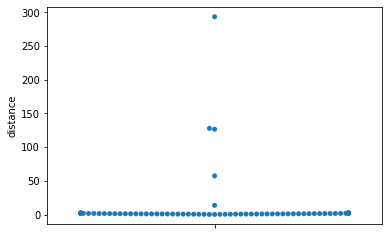

In [31]:
import matplotlib.pyplot as plt 
import seaborn as sns

sns.swarmplot(y=ward_df['distance'])
plt.show()

Luckily, only a few ward have wrong value.  
With the majority distance fall in the range of about 2km, we will remove those row with distance larger than 5km

### III. 4. b. Remove ward with incorrect coordinate data

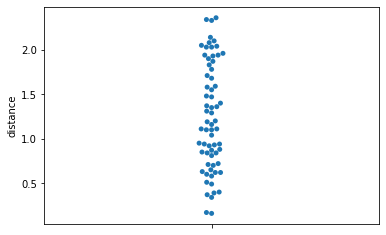

In [32]:
ward_df.drop(ward_df.index[ward_df['distance']>10], axis=0, inplace=True)
ward_df.reset_index(inplace=True, drop=True)

# Look again
sns.swarmplot(y=ward_df['distance'])
plt.show()

Draw them on map

In [33]:
map = drawMap(latitude, longitude, geodf, zoom=13)
map = addMarker(map, ward_df,['w_lat', 'w_lon'],'CM', 2, 'red', ['d_en_name', 'w_en_name'])
map

In [34]:
# Save the ward list to use later
ward_df.to_csv('ward_list.csv', index=False)

Look good now. We can start exploring Hanoi.

# IV. Exploring Hanoi using Foursquare API

## IV. 1. Review data

Take a look at our dataframe again

In [35]:
# Open data from saved ward list in case failed to get data from OSM
with io.open('ward_list.csv', encoding='utf8') as file:
    ward_df = pd.read_csv(file)

print('There are',ward_df.shape[0],'wards in total')
ward_df.head()

There are 67 wards in total


,d_code,d_en_name,d_vi_name,d_lat,d_lon,d_url,w_name,w_en_name,w_url,w_lat,w_lon,distance
0,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,Cống Vị,Cong Vi,https://vi.wikipedia.org/wiki/C%E1%BB%91ng_V%E...,21.035670,105.810235,1.94
1,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,Điện Biên,Dien Bien,https://vi.wikipedia.org/wiki/%C4%90i%E1%BB%87...,21.030667,105.838350,1.11
2,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,Đội Cấn,Doi Can,https://vi.wikipedia.org/wiki/%C4%90%E1%BB%99i...,21.034881,105.830439,0.17
3,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,Giảng Võ,Giang Vo,https://vi.wikipedia.org/wiki/Gi%E1%BA%A3ng_V%...,21.025784,105.818820,1.48
4,1,Ba Dinh District,Ba Đình,21.035252,105.828854,https://vi.wikipedia.org/wiki/Th%E1%BB%83_lo%E...,Kim Mã,Kim Ma,https://vi.wikipedia.org/wiki/Kim_M%C3%A3,21.031279,105.826369,0.51


Since those URL no longer needed, we can drop them

In [36]:
ward_df.drop(['d_url', 'w_url'], axis=1, inplace=True)
ward_df.head()

# Set df as alias for ward_df
df = ward_df

Let's see if we search for venues in the 800m radius from the center of ward, will there be any overlapping.

In [37]:
map = drawMap(latitude, longitude, geodf, zoom=13)
map = addMarker(map, df,['w_lat', 'w_lon'],'C', 800, 'red', ['w_en_name'])
map

## IV. 2. Grouping wards

The distribution of ward  in some district are dense. We should group them and treat them as 1 node to reduce API call and duplicate result. The best algorithm to use for data with latitude and longitude is DBSCAN.

First, we need to create a dataframe with latitude and longitude data

In [38]:
df_sel = df.copy()
df_grouped = df_sel[['w_lat', 'w_lon']]
df_grouped.head()

,w_lat,w_lon
0,21.035670,105.810235
1,21.030667,105.838350
2,21.034881,105.830439
3,21.025784,105.818820
4,21.031279,105.826369


To compute DBSCAN, we need some parameter
- $\epsilon$ represent the maximum distance. In our case, we will set it as 1000m (1km)
- min_samples - the minimum cluster size allowed, everything lower will be considers as noise. In our case, we will set it to 1 so any ward will be belong to a cluster

As we will use haversine metric with a ball tree space-partitionning data structure to calculate great-circle distances between points, we will have to convert it to radians.

In [39]:
import numpy as np
from sklearn.cluster import DBSCAN

# Declare parameter for DBSCAN
# max distance in meter
max_distance = 500
min_samples = 1

coords = df_grouped.to_numpy()

kmpr  = 6371.0088
epsilon = (max_distance/(1000*kmpr))
db = DBSCAN(eps=epsilon, min_samples = min_samples, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))

print('Cluster labels:', cluster_labels)
print(num_clusters, 'clusters')

df_sel['Cluster']=cluster_labels
df_sel.head()

Cluster labels: [ 0  1  2  3  4  5  6  7  8  8  9 10 11 12 13  8 14  8  8 15  8  8  8  8
  8  8  8  8 15  8 15 16 17 18 19 20 21 22  4 23 24 25 26 27 28 25 29  1
 30 24 29 24 25 24  1 31 32 33 33 34 15 35 31 31 36 37 38]
39 clusters


,d_code,d_en_name,d_vi_name,d_lat,d_lon,w_name,w_en_name,w_lat,w_lon,distance,Cluster
0,1,Ba Dinh District,Ba Đình,21.035252,105.828854,Cống Vị,Cong Vi,21.035670,105.810235,1.94,0
1,1,Ba Dinh District,Ba Đình,21.035252,105.828854,Điện Biên,Dien Bien,21.030667,105.838350,1.11,1
2,1,Ba Dinh District,Ba Đình,21.035252,105.828854,Đội Cấn,Doi Can,21.034881,105.830439,0.17,2
3,1,Ba Dinh District,Ba Đình,21.035252,105.828854,Giảng Võ,Giang Vo,21.025784,105.818820,1.48,3
4,1,Ba Dinh District,Ba Đình,21.035252,105.828854,Kim Mã,Kim Ma,21.031279,105.826369,0.51,4


Get centroid of each cluster

In [40]:
cluster_df = pd.DataFrame(columns=['label', 'lat', 'lon'])

for l in range(num_clusters):
    lat = df_sel.loc[df_sel['Cluster']==l, 'w_lat'].mean()
    lon = df_sel.loc[df_sel['Cluster']==l, 'w_lon'].mean()
    cluster_df = cluster_df.append({'label':l, 'lat': lat, 'lon': lon}, ignore_index=True)

cluster_df=cluster_df.astype({'label': int})
print(cluster_df.shape)
cluster_df.head()

(39, 3)


,label,lat,lon
0,0,21.035670,105.810235
1,1,21.028449,105.836407
2,2,21.034881,105.830439
3,3,21.025784,105.818820
4,4,21.030623,105.827690


We set search radius at 800m

In [41]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# Function to add cluster to map
def addCluster(mObj, cl_df, s_rad, opa=0.5):
    x = np.arange(cl_df.shape[0])
    ys = [i + x + (i*x)**2 for i in range(cl_df.shape[0])]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]

    for lat, lon, cluster, idx in zip(cl_df['lat'], cl_df['lon'], cl_df['label'], cl_df.index.values):
        label = folium.Popup('Cluster ' + str(cluster), parse_html=True)
        folium.Circle(
            [lat, lon],
            radius=s_rad,
            popup=label,
            color=rainbow[idx-1],
            fill=True,
            fill_color=rainbow[idx-1],
            fill_opacity=0.5).add_to(mObj)
    return mObj

In [42]:
s_radius = 800

# create map
map_clusters = drawMap(latitude, longitude, geodf, zoom=13)

map_clusters = addCluster(map_clusters, cluster_df, s_radius)    

map_clusters

Look fairly good. So we proceed to find the venue near these coordinates.

## IV. 3. Exploring with FourSquare API

### IV. 3. a. Declare FourSquare API credential and variables

In [43]:
c_id = 'MJGJUZATDKEM3AKB5HJNBSDOEDWOZXKNYH0HCYDWC5JO11BA' # your Foursquare ID
c_secret = '42BNYWBCCGBWRJO30ZZJVPDUKBWU20DBBDL2GJFOQHGO13BW' # your Foursquare Secret
ver = '20200220' # Foursquare API version

limit = 100
# List of categorries that we interested in, in order: food, hotel, art & entertainment
cat_list = {'restaurant':'4d4b7105d754a06374d81259'
            ,'hotel': '4bf58dd8d48988d1fa931735'
            ,'entertainment': '4d4b7104d754a06370d81259'}

Function to query venues list from FourSquare

In [44]:
def get_4Square_venues(loc_list, cat_list):
    res = []
    for loc in loc_list:
        print('Cluster', loc[0],'...', end='')
        for cat in cat_list:
            url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            c_id, c_secret, ver, loc[1], loc[2], cat_list[cat], s_radius, limit)
            results = requests.get(url).json()['response']['groups'][0]['items']

            res.append([(
            loc[0], 
            loc[1], 
            loc[2], 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            cat) for v in results])
        
        nearby_venues = pd.DataFrame([item for r in res for item in r])
        nearby_venues.columns = ['c_label', 
                  'c_lat', 
                  'c_lon',
                  'v_id',
                  'v_name', 
                  'v_lat', 
                  'v_lon', 
                  'v_cat',
                  'm_cat']

    return nearby_venues

### IV. 3. b. Query data from FourSquare

Get the venues list for nearest to our cluster centroids

In [45]:
venues_list = pd.DataFrame()

print('Getting data...')
venues_list = venues_list.append(get_4Square_venues(zip(cluster_df['label'], cluster_df['lat'], cluster_df['lon']), cat_list))

print('\nDone!')

Getting data...
Cluster 0 ...Cluster 1 ...Cluster 2 ...Cluster 3 ...Cluster 4 ...Cluster 5 ...Cluster 6 ...Cluster 7 ...Cluster 8 ...Cluster 9 ...Cluster 10 ...Cluster 11 ...Cluster 12 ...Cluster 13 ...Cluster 14 ...Cluster 15 ...Cluster 16 ...Cluster 17 ...Cluster 18 ...Cluster 19 ...Cluster 20 ...Cluster 21 ...Cluster 22 ...Cluster 23 ...Cluster 24 ...Cluster 25 ...Cluster 26 ...Cluster 27 ...Cluster 28 ...Cluster 29 ...Cluster 30 ...Cluster 31 ...Cluster 32 ...Cluster 33 ...Cluster 34 ...Cluster 35 ...Cluster 36 ...Cluster 37 ...Cluster 38 ...
Done!


Take a look at our new dataframe

In [46]:
print(venues_list.groupby('m_cat')['m_cat'].count())
venues_list.head()

m_cat
entertainment     215
hotel             595
restaurant       1255
Name: m_cat, dtype: int64


,c_label,c_lat,c_lon,v_id,v_name,v_lat,v_lon,v_cat,m_cat
0,0,21.03567,105.810235,5b122b72ccad6b003934e0aa,Pizza 4P,21.034181,105.812777,Pizza Place,restaurant
1,0,21.03567,105.810235,5c29f521018cbb002c11e5b3,Pizza 4Ps Lotte Hanoi,21.032145,105.813378,Pizza Place,restaurant
2,0,21.03567,105.810235,53ddc0d0498e3f6004459411,喰龍,21.035948,105.810525,Japanese Restaurant,restaurant
3,0,21.03567,105.810235,53870362498e799514545c1e,Joma Bakery Café,21.034469,105.814143,Café,restaurant
4,0,21.03567,105.810235,55d1a43e498e74ab524cdf91,Hue Restaurant,21.032959,105.808500,Vietnamese Restaurant,restaurant


Let's see the number of venues of each cluster

In [47]:
venues_list.groupby('c_label').count()

,c_lat,c_lon,v_id,v_name,v_lat,v_lon,v_cat,m_cat
c_label,,,,,,,,
0,57,57,57,57,57,57,57,57
1,71,71,71,71,71,71,71,71
2,33,33,33,33,33,33,33,33
3,54,54,54,54,54,54,54,54
4,57,57,57,57,57,57,57,57
5,37,37,37,37,37,37,37,37
6,24,24,24,24,24,24,24,24
7,68,68,68,68,68,68,68,68
8,210,210,210,210,210,210,210,210


Since our cluster search radius is overlap, our dataframe will have duplicate venue that belong to many cluster. Let's take a look

In [48]:
venues_list[venues_list.duplicated(subset=['v_id'])].sort_values(by=['v_name'])

,c_label,c_lat,c_lon,v_id,v_name,v_lat,v_lon,v_cat,m_cat
734,11,21.045080,105.842459,4ca48986554b236a96da2f48,1946,21.042919,105.842949,Vietnamese Restaurant,restaurant
1654,29,21.012222,105.822083,4efaa839c512f2277b71db0d,1946,21.018830,105.821899,Vietnamese Restaurant,restaurant
1951,35,21.012222,105.851667,55e280e1498e77ce6ed3316e,21six Cafe,21.014850,105.849130,Café,restaurant
1188,15,21.021313,105.854270,4e637285b61cd78088fbab71,33 Pham Ngu Lao Swimming Pool,21.022490,105.860156,Hotel Pool,hotel
732,11,21.045080,105.842459,4f817643e4b0ac16a2af36fc,5 spice Restaurant,21.041584,105.848212,Vietnamese Restaurant,restaurant
...,...,...,...,...,...,...,...,...,...
1205,16,21.022732,105.847462,56f4d384498e861a6325dd75,Ưu Đàm Chay,21.022366,105.852487,Vegetarian / Vegan Restaurant,restaurant
676,10,21.020663,105.815323,546f4098498e2d4d056cc1da,博多幸龍,21.020768,105.817985,Ramen Restaurant,restaurant
278,5,21.037468,105.817602,53ddc0d0498e3f6004459411,喰龍,21.035948,105.810525,Japanese Restaurant,restaurant
347,7,21.029429,105.811065,53ddc0d0498e3f6004459411,喰龍,21.035948,105.810525,Japanese Restaurant,restaurant


We can drop the duplicate entries but I decided to keep them so we can calculate easier later.

Instead we we create new dataframe named **venues_list_u** to use for map drawing

In [49]:
# Drop duplicate entries from our dataframe
venues_list_u = venues_list.drop_duplicates(subset=['v_id'])
venues_list_u.reset_index(inplace=True, drop=True)

print('There are', venues_list_u.shape[0], 'unique entries in venues list. Including:')
print('- ', venues_list_u[venues_list_u['m_cat']=='restaurant'].shape[0],' restaurants\n'
      ,'- ', venues_list_u[venues_list_u['m_cat']=='hotel'].shape[0],' hotels\n'
      ,'- ', venues_list_u[venues_list_u['m_cat']=='entertainment'].shape[0],' entertainment venues\n', sep='')

#venues_list_u.head()

There are 1232 unique entries in venues list. Including:
- 725 restaurants
- 362 hotels
- 145 entertainment venues



### IV. 3. c. Visualization

Let's view the location of these venues on our map.

In [50]:
map_w_venues = drawMap(latitude, longitude, geodf, zoom=13)

map_w_venues = addCluster(map_w_venues, cluster_df, s_radius, 0.3)

# Add restaurant marker with color red
print('Add restaurant markers...')
map_w_venues = addMarker(map_w_venues, venues_list_u[venues_list_u['m_cat'] == 'restaurant'],['v_lat', 'v_lon'],'CM', 1, 'red', ['v_name'])

# Add hotel marker with color blue
print('Add hotel markers...')
map_w_venues = addMarker(map_w_venues, venues_list_u[venues_list_u['m_cat'] == 'hotel'],['v_lat', 'v_lon'],'CM', 1, 'blue', ['v_name'])

# Add entertainment marker with color yellow
print('Add entertainment venues markers...')
map_w_venues = addMarker(map_w_venues, venues_list_u[venues_list_u['m_cat'] == 'entertainment'],['v_lat', 'v_lon'],'CM', 1, 'yellow', ['v_name'])

map_w_venues

Add restaurant markers...
Add hotel markers...
Add entertainment venues markers...


## IV. 4. Methodology

We will have to do these things:
- Build a map of Hanoi main districts
- Base on the list of main districts, get list of wards (includng coordinates) that belong to them
- Group wards into cluster using DBSCAN to reduce number of API call
- Drop those clusters with too few venues
- Calculate the density of each category of each type of venue and decide where we want to stay.  

## IV. 5. Analyzing

Take a look at number of venues in each cluster

In [51]:
venues_list.groupby('c_label')['v_name'].count()

c_label
0      57
1      71
2      33
3      54
4      57
5      37
6      24
7      68
8     210
9      65
10     37
11    100
12     15
13     99
14    115
15    162
16    159
17     36
18     12
19      6
20     21
21     46
22     14
23     38
24     30
25     29
26     28
27     16
28     13
29     54
30     35
31     13
32     34
33     66
34     66
35     80
36     12
37     30
38     23
Name: v_name, dtype: int64

In [52]:
venues_list.groupby('c_label')['v_name'].count().describe()

count     39.000000
mean      52.948718
std       45.311175
min        6.000000
25%       23.500000
50%       37.000000
75%       66.000000
max      210.000000
Name: v_name, dtype: float64

We will drop those clusters with less than 37 venues

In [53]:
drop_list = cluster_df[venues_list.groupby('c_label')['v_name'].count()<37].index

cluster_df_sel = cluster_df.drop(drop_list).reset_index(drop=True)

print(cluster_df_sel.shape)
#cluster_df_sel.head()

(20, 3)


We also remove the venues belong to the removed cluster from our venues list

In [54]:
# Get list of row to drop
venues_drop_list = venues_list[venues_list['c_label'].isin(drop_list)].index

# Drop
venues_list_sel = venues_list.drop(venues_drop_list).reset_index(drop=True)

# Create new unique venues dataframe
venues_list_u_sel = venues_list_sel.drop_duplicates(subset=['v_id']).reset_index(drop=True)

Take a look at our new map

In [55]:
# Copy the map with cluster object
map_sel = drawMap(latitude, longitude, geodf, zoom=13)

map_sel = addCluster(map_sel, cluster_df_sel, s_radius, 0.3)

# Add restaurant marker with color red
print('Add restaurant markers...')
map_sel = addMarker(map_sel, venues_list_u_sel[venues_list_u_sel['m_cat'] == 'restaurant'],['v_lat', 'v_lon'],'CM', 1, 'red', ['v_name'])

# Add hotel marker with color blue
print('Add hotel markers...')
map_sel = addMarker(map_sel, venues_list_u_sel[venues_list_u_sel['m_cat'] == 'hotel'],['v_lat', 'v_lon'],'CM', 1, 'blue', ['v_name'])

# Add entertainment marker with color yellow
print('Add entertainment venues markers...')
map_sel = addMarker(map_sel, venues_list_u_sel[venues_list_u_sel['m_cat'] == 'entertainment'],['v_lat', 'v_lon'],'CM', 1, 'yellow', ['v_name'])

map_sel

Add restaurant markers...
Add hotel markers...
Add entertainment venues markers...


With the cluster with low number of venues removed, we take a look at the distribution of each master category in remaining cluster

Define function to calculate the percentage

In [56]:
def cal_percentage(data_df, label):
    p={}
    p['label'] = label
    total = data_df.shape[0]
    p['restaurant'] = round((data_df[data_df['m_cat'] == 'restaurant'].shape[0]/total)*100, 2)
    p['hotel'] = round((data_df[data_df['m_cat'] == 'hotel'].shape[0]/total)*100, 2)
    p['entertainment'] = round(100 - (p['restaurant']+p['hotel']), 2)
    
    return p

In [57]:
percent_list = []

for l in cluster_df_sel['label']:
    percent_list.append(cal_percentage(venues_list_sel[venues_list_sel['c_label']==l], l))

cluster_percent = cluster_df_sel.merge(pd.DataFrame(percent_list), left_on='label', right_on='label')
cluster_percent.drop(columns=['lat', 'lon'], inplace=True)
#cluster_percent.sort_values(by='restaurant', ascending=False, inplace=True)
cluster_percent.set_index('label', inplace=True)

cluster_percent.head()



,restaurant,hotel,entertainment
label,,,
0,78.95,14.04,7.01
1,66.20,28.17,5.63
3,77.78,14.81,7.41
4,75.44,14.04,10.52
5,72.97,21.62,5.41


Visualize it

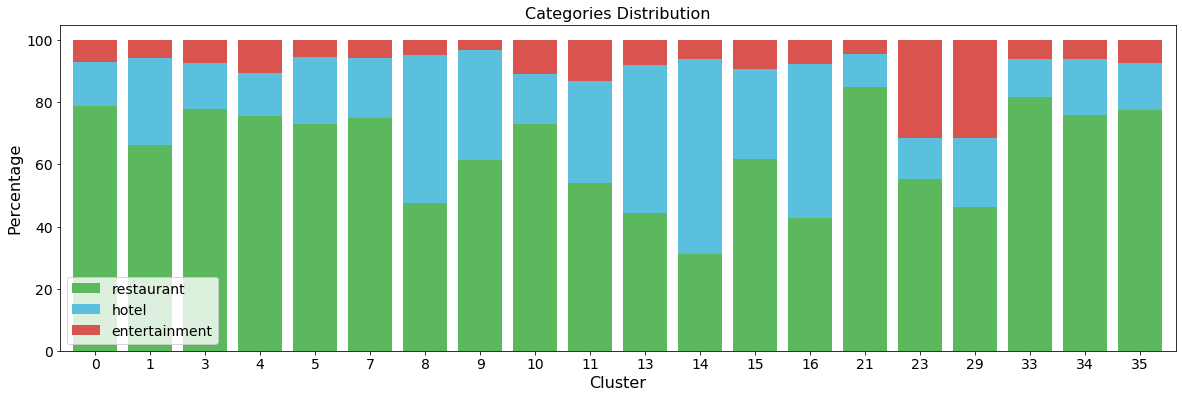

In [58]:
ax = cluster_percent['restaurant'].plot(kind='bar', figsize=(20,6), width=0.8, color = ['#5cb85c'], fontsize=14)
ax = cluster_percent['hotel'].plot(kind='bar', bottom=cluster_percent['restaurant'], width=0.8, color = ['#5bc0de'])
ax = cluster_percent['entertainment'].plot(kind='bar', bottom=[i+j for i,j in zip(cluster_percent['restaurant'], cluster_percent['hotel'])], width=0.8, color = ['#d9534f'])

ax.set_title('Categories Distribution', fontsize=16);
ax.set_xlabel('Cluster', fontsize=16);
ax.set_ylabel('Percentage', fontsize=16);
ax.legend(fontsize=14)
ax.set_xticklabels(cluster_percent.index.values, rotation=0);

From the above chart, and based on my need:

>area with **many** ***restaurant***, **not so few**  ***hotels*** and ***entertainment venues***

We can choose cluster **1, 5, 7, 11, 15, 23, 29** as our candidates

In [59]:
selected_clusters = [1, 5, 7, 11, 15, 23, 29]

#Filter our data
cluster_df_sel = cluster_df_sel[cluster_df_sel['label'].isin(selected_clusters)].reset_index(drop=True)
venues_list_sel = venues_list_sel[venues_list_sel['c_label'].isin(selected_clusters)].reset_index(drop=True)
venues_list_u_sel = venues_list_sel.drop_duplicates(subset=['v_id']).reset_index(drop=True)

Let's take a look at what kind of venues is most popular in our selected cluster

In [60]:
# Define function to get top sub-category of master category
def create_onehot(data_df):
    onehot_df = pd.get_dummies(data_df[['v_cat']], prefix="", prefix_sep="")

    onehot_df['c_label'] = data_df['c_label'] 

    # move cluster label column to the first column
    fixed_columns = [onehot_df.columns[-1]] + list(onehot_df.columns[:-1])
    onehot_df = onehot_df[fixed_columns]

    onehot_df = onehot_df.groupby('c_label').mean().reset_index()
    return onehot_df

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

def build_top_cat_df(data_df, num_top):
    
    onehot_df = create_onehot(data_df)
    
    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['cluster_label']
    for ind in np.arange(num_top):
        try:
            columns.append('{}{} most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th most Common Venue'.format(ind+1))

    # create a new dataframe
    sorted_df = pd.DataFrame(columns=columns)
    sorted_df['cluster_label'] = cluster_df_sel['label']
    
    for ind in np.arange(sorted_df.shape[0]):
        sorted_df.iloc[ind, 1:] = return_most_common_venues(onehot_df.iloc[ind, :], num_top)
    
    return sorted_df

Set number of top sub-categories

In [61]:
num_top_venues = 10

We will left out all of the hotel on our list of most common venue because I can adapt to any kind of accommodation

In [62]:
hn_sorted = build_top_cat_df(venues_list_sel[venues_list_sel['m_cat']!='hotel'], num_top_venues)

hn_sorted

,cluster_label,1st most Common Venue,2nd most Common Venue,3rd most Common Venue,4th most Common Venue,5th most Common Venue,6th most Common Venue,7th most Common Venue,8th most Common Venue,9th most Common Venue,10th most Common Venue
0,1,Vietnamese Restaurant,Café,Noodle House,Sandwich Place,Asian Restaurant,Bakery,Korean Restaurant,Mongolian Restaurant,Food,Malay Restaurant
1,5,Café,Noodle House,Pizza Place,Japanese Restaurant,Vietnamese Restaurant,Sushi Restaurant,Steakhouse,Dim Sum Restaurant,Piano Bar,Multiplex
2,7,Japanese Restaurant,Café,Korean Restaurant,Vietnamese Restaurant,Multiplex,Noodle House,Pizza Place,Sushi Restaurant,Dim Sum Restaurant,Czech Restaurant
3,11,Vietnamese Restaurant,Café,Noodle House,Art Gallery,Hotpot Restaurant,Vegetarian / Vegan Restaurant,Movie Theater,Music Venue,French Restaurant,Bakery
4,15,Vietnamese Restaurant,Café,Noodle House,Steakhouse,Italian Restaurant,Bakery,French Restaurant,Sushi Restaurant,Restaurant,Theater
5,23,Café,Music Venue,Vietnamese Restaurant,Noodle House,Fast Food Restaurant,Art Gallery,Salsa Club,Bakery,Pizza Place,Dance Studio
6,29,Café,Art Gallery,Music Venue,Vietnamese Restaurant,Fast Food Restaurant,Seafood Restaurant,Noodle House,Multiplex,Asian Restaurant,Circus


Based on my preference, we will remove cluster **23 and 29** from our selection because the most common venue in them is heavyly lean on entertainment. And we have our final candidates is cluster **1, 5, 7, 11, 15**

In [63]:
selected_clusters = [1, 5, 7, 11, 15]

#Filter our data
cluster_df_sel = cluster_df_sel[cluster_df_sel['label'].isin(selected_clusters)].reset_index(drop=True)
venues_list_sel = venues_list_sel[venues_list_sel['c_label'].isin(selected_clusters)].reset_index(drop=True)
venues_list_u_sel = venues_list_sel.drop_duplicates(subset=['v_id']).reset_index(drop=True)

# Get the list of wards that belong to the remaining cluster
ward_df_final = df_sel[df_sel['Cluster'].isin(selected_clusters)]

Let's show these clusters and wards on map.

In [64]:
map_sel = drawMap(latitude, longitude, geodf, zoom=13)

map_sel = addCluster(map_sel, cluster_df_sel, s_radius, 0.3)

# Add marker for wards
map_sel = addMarker(map_sel, ward_df_final, ['w_lat', 'w_lon'],'CM', 2, 'blue', ['w_name'])

map_sel

In [65]:
print('Recommended ward to stay during your time in Hanoi is')
for d in ward_df_final['d_en_name'].unique():
    print('\n', d)
    for w in ward_df_final[ward_df_final['d_en_name']==d]['w_en_name']:
        print('\t', w)

Recommended ward to stay during your time in Hanoi is

 Ba Dinh District
	 Dien Bien
	 Lieu Giai
	 Ngoc Khanh
	 Truc Bach

 Hoan Kiem District
	 Hang Bai
	 Phan Chu Trinh
	 Trang Tien

 Dong Da District
	 Quoc Tu Giam
	 Van Mieu

 Hai Ba Trung District
	 Pham Dinh Ho


# V. Result & Discussion

Our analysis help us narrow down the number of ward to choose to stay during our time in Hanoi. From a person that don't know much about Hanoi, during our project, we were go from search for list of districts, list of wards in each district and then the venues belong to them.

We used DBSCAN to group those wards together, result in decreasing FourSquare API call.

Based on my criterias, the analysis help us reveal 10 wards that best suite for me. This is the material to further research and choose the most suitable place in Hanoi for a traveller.